# <font color='firebrick'>Problem Set \#5:</font> Due Sunday, December 4, 2022



Answer the questions below. This notebook will be your workspace so add cells as you please. when you're done, submit your notebook as a pdf. [To print: From the file menu, choose 'print preview'. A new tab will open with the notebook presented as html. Print as a pdf.] Save your pdf notebook with the naming convention **'PS5_[insert last name]'**. For example, 'PS5_Thurk.pdf'. 

**You can work with others on this assignment but must turn in your own solutions.**

**Grading:** The problem set is worth **60 points** and partial credit is indicated for each exercise.

**A reminder:** My office hours are Wednesdays 3:00PM-5:00PM EST, by appointment (ie, send me an email and we'll set up a time), and on Friday 11:00AM to 12:00PM EST via zoom. See syllabus for link.

# Name: <font color= red>Daniel Saul</font>

# Exercise 1: Load Data on App Reviews [10 points]

Just run the cells below and earn 10 points! You will need to be connected to the internet and have the following package which provides the APIs to easily crawl the Google Play Store:

```python
pip install --upgrade google_play_scraper  # added "upgrade" in the event you already have it
```

In [2]:
import json   # package for storing data (kind of like a csv format)
import pandas as pd
import numpy as np
from tqdm import tqdm   # package to show progress

import seaborn as sns
import matplotlib.pyplot as plt

# some fancy stuff to highlight results
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

# just installed scraper for the google play store
from google_play_scraper import Sort, reviews, app

In [3]:
# List of Apps and their packages to be collected. Here I choose some Apps under the category 'productivity'
# and grabbed the amazon app. Try grabbing something else...
app_packages = [
    'com.amazon.mShop.android.shopping']

## Scraping App Information

In [4]:
app_infos = []

for ap in app_packages:  # loop through the apps and scrape the data from the play store (here, only one)
    info = app(ap, lang='en', country='us') # from the US market
    del info['comments']
    app_infos.append(info)

Let's look at the corresponding JSON objects:

In [5]:
def print_json(json_object):
    json_str = json.dumps(
        json_object, 
        indent=2, 
        sort_keys=True, 
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [6]:
print_json(app_infos[0])

{
  "adSupported": true,
  "appId": "com.amazon.mShop.android.shopping",
  "containsAds": true,
  "contentRating": "Teen",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "<h2><b>Product Features</b></h2>\r\nAmazon Shopping offers app-only benefits to help make shopping on Amazon faster and easier than shopping on your desktop.\r\n\r\n<h2><b>Never miss a delivery</b></h2>\r\nGet real-time tracking and delivery notifications so you know where your package is and when it arrives. \r\n\r\n<h2><b>Know exactly what you\u2019re purchasing</b></h2>\r\nFull 360\u00b0 product view lets you see items from every angle. \u201cView in you room\u201d makes sure it fits by using your phone\u2019s camera and VR so you can see it in your space. \r\n\r\n<h2><b>We\u2019ll notify you when items go on sale</b></h2>\r\nJust tap the heart icon to save items to Your Lists and we\u2019ll alert you of price drops so you don\u2019t miss a deal. \r\n\r\n<h2><b>Never forget your password<

This contains a lot of information including the number of ratings, number of reviews, and the number of ratings for each score (1 to 5). We can select what is relevant and even some of the info we like. For example, we can print the logos.

/var/folders/51/h1nmh05j5mz75s5kwn0ngjxr0000gn/T/ipykernel_44004/572773085.py:15: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  img = plt.imread(ai['icon'])


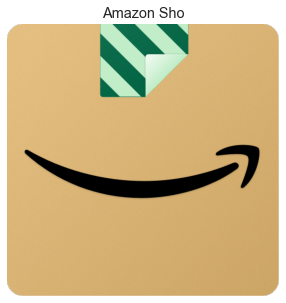

In [7]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Function to format and get the title
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

# Print logos and titles
fig, ax = plt.subplots(1, len(app_infos) // 1, figsize=(14, 5))

ai = app_infos[0]
img = plt.imread(ai['icon'])
ax.imshow(img)
ax.set_title(format_title(ai['title']))
ax.axis('off')
plt.show()

## Scraping App Reviews

We're interested in collecting reviews so run the code below to scrape all reviews for each app in `app_packages`. Here, that's boring because there is only one app but now you have some code to scale things up if you want. Note that we're adding the "app id" and sort order to each review.

In [8]:
app_reviews = []

# Loop through all the app packages and collect review for each of them
for ap in tqdm(app_packages):  # NB, tqdm here isn't very insightful since there is only one app to loop through
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en',
                country='us',
                sort=sort_order,
                filter_score_with=score,
                count= 2000  # retrieve 2000 reviews for each score
            )
        for r in rvs:
            r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
            r['appId'] = ap

        app_reviews.extend(rvs)
        
# count= 2000 if score == 3 else 2050,

100%|█████████████████████████████████████████████| 1/1 [00:50<00:00, 50.17s/it]


In [9]:
print('We were able to scrape: ', len(app_reviews), " reviews")

We were able to scrape:  10000  reviews


Let's save the scrape to a csv file so we don't have to keep running the above lines when we're analyzing the data for trends.

In [10]:
# Save app reviews in a CSV format
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('amazonreviews.csv', index=None, header=True)

# Exercise 2: Develop a ML Model to Classify Ratings [20 points]

### 2.1 Load the data.

Make sure the "content" field is a string. Rename the "at" column "date" and convert it to datetime. Keep "date", "content", and "score". 

In [39]:
# load data
app_reviews_df = pd.read_csv('amazonreviews.csv')

# convert content field to string
app_reviews_df['content'] = app_reviews_df['content'].astype('string')

# rename at column to date
app_reviews_df = app_reviews_df.rename({'at':'date'}, axis=1)

# convert date column to datetime
app_reviews_df['date'] = pd.to_datetime(app_reviews_df['date'])

# keep three requested columns
app_reviews_df = app_reviews_df[['date', 'content', 'score']]

# check column types and see remaining columns
app_reviews_df.dtypes

date       datetime64[ns]
content            string
score               int64
dtype: object

### 2.2 Classify reviews

Classify reviews into "positive" and "negative" using the customer scores. 

* We'll call positive reviews any review with a `score` greater than three. 

* Negative reviews will be any reviews with a `score` less than three.

Drop neutral scores (`score` of three).

In [40]:
# drop neutral scores
app_reviews_df = app_reviews_df[app_reviews_df['score'] != 3]

# classify reviews
app_reviews_df['review_type'] = np.where(app_reviews_df['score'] > 3, 'positive', 'negative')
app_reviews_df['sentiment'] = app_reviews_df['score'].apply(lambda score : 1 if score > 3 else 0)

app_reviews_df.head()

,date,content,score,review_type,sentiment
0,2022-12-03 10:39:41,App is extremely sluggish. The new interface i...,1,negative,0
1,2022-12-03 10:07:02,I never received my package said it was given ...,1,negative,0
2,2022-12-03 09:39:21,They closed my account without providing any r...,1,negative,0
3,2022-12-03 09:26:00,"For swiss People, it's almost impossible to se...",1,negative,0
4,2022-12-03 08:24:58,The live streams gotta go. You make it extra s...,1,negative,0


### 2.3 Process the text data.
    * remove non-alphabetic characters
    * convert to lower case
    * tokenize the strings
    * stem and lem

In [41]:
# remove non-alphabetic characters
app_reviews_df['content'] = app_reviews_df['content'].str.replace('[^A-Za-z]', ' ', regex=True)
app_reviews_df.head()

,date,content,score,review_type,sentiment
0,2022-12-03 10:39:41,App is extremely sluggish The new interface i...,1,negative,0
1,2022-12-03 10:07:02,I never received my package said it was given ...,1,negative,0
2,2022-12-03 09:39:21,They closed my account without providing any r...,1,negative,0
3,2022-12-03 09:26:00,For swiss People it s almost impossible to se...,1,negative,0
4,2022-12-03 08:24:58,The live streams gotta go You make it extra s...,1,negative,0


In [42]:
# convert to lower case
app_reviews_df['content'] = app_reviews_df['content'].str.lower()
app_reviews_df.head()

,date,content,score,review_type,sentiment
0,2022-12-03 10:39:41,app is extremely sluggish the new interface i...,1,negative,0
1,2022-12-03 10:07:02,i never received my package said it was given ...,1,negative,0
2,2022-12-03 09:39:21,they closed my account without providing any r...,1,negative,0
3,2022-12-03 09:26:00,for swiss people it s almost impossible to se...,1,negative,0
4,2022-12-03 08:24:58,the live streams gotta go you make it extra s...,1,negative,0


In [43]:
# install tokenize packages
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize as wt

# drop null values causing issues
app_reviews_df = app_reviews_df.dropna()

# tokenize the strings
app_reviews_df['content'] = app_reviews_df['content'].apply(wt)
app_reviews_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielsaul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,date,content,score,review_type,sentiment
0,2022-12-03 10:39:41,"[app, is, extremely, sluggish, the, new, inter...",1,negative,0
1,2022-12-03 10:07:02,"[i, never, received, my, package, said, it, wa...",1,negative,0
2,2022-12-03 09:39:21,"[they, closed, my, account, without, providing...",1,negative,0
3,2022-12-03 09:26:00,"[for, swiss, people, it, s, almost, impossible...",1,negative,0
4,2022-12-03 08:24:58,"[the, live, streams, got, ta, go, you, make, i...",1,negative,0


In [44]:
# stem and lem
from nltk.stem.porter import PorterStemmer
def stem_it(x):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in x]

app_reviews_df['content'] = app_reviews_df['content'].apply(stem_it)

app_reviews_df.head()

,date,content,score,review_type,sentiment
0,2022-12-03 10:39:41,"[app, is, extrem, sluggish, the, new, interfac...",1,negative,0
1,2022-12-03 10:07:02,"[i, never, receiv, my, packag, said, it, wa, g...",1,negative,0
2,2022-12-03 09:39:21,"[they, close, my, account, without, provid, an...",1,negative,0
3,2022-12-03 09:26:00,"[for, swiss, peopl, it, s, almost, imposs, to,...",1,negative,0
4,2022-12-03 08:24:58,"[the, live, stream, got, ta, go, you, make, it...",1,negative,0


In [45]:
# Join the list we created in each observation of the "content" field
app_reviews_df['content'] = app_reviews_df['content'].str.join(' ')

### 2.4 Vectorize the model.

Convert the text via the count `CountVectorizer`. In class we did this for each word but we can instead vectorize according to phrases, or "n-grams". Vectorize according to two-word phrases (2-grams) using

```python
matrix = CountVectorizer(max_features=10000, ngram_range = (2, 2))  # bag-of-words with bigrams
```

Create your X matrix using `fit_transform` on the review field of the df. The outcome variable is of course the score field of the df.

You can visualize the vectorized bi-grams using
```python
df = pd.DataFrame(data = X, columns = matrix.get_feature_names_out())
df.head()
```

In [46]:
# import packages
from sklearn.feature_extraction.text import CountVectorizer

# convert text via count
matrix = CountVectorizer(max_features=10000, ngram_range = (2, 2))

# create X matrix
X = matrix.fit_transform(app_reviews_df['content']).toarray()

# create y variable for testing
y = app_reviews_df['sentiment']

In [48]:
# visualize the vectorized bi-grams using
df = pd.DataFrame(data = X, columns = matrix.get_feature_names_out())
df.head()

,abil to,abl to,about amazon,about an,about and,about anyth,about as,about deliveri,about everi,about everyth,...,your stupid,your subscript,your time,your wish,yup yup,zero help,zero star,zip code,zzz zz,zzz zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.5 Split the data into training and testing data using `train_test_split`.

In [49]:
# import packages
from sklearn.model_selection import train_test_split

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

### 2.6 Develop the model

Tune and fit a Support Vector Machine (SVM) ML model and evaluate the fit. Try different values of the regularization parameter `C`, `gamma` as well as different `kernels`.

In [22]:
# import packages
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [26]:
# Define grid of values to do CV. 
param_grid = {'C': [1, 2, 3, 4, 5],
              'kernel': ['linear']}

grid = GridSearchCV(SVC(), param_grid)   # 5-fold CV used as default (ie, 'cv=5')

# Fit the model via cross-validation on 
grid.fit(X_train, y_train)
print('The optimal parameters are:')
print(grid.best_params_)

The optimal parameters are:
{'C': 1, 'kernel': 'linear'}


In [27]:
# Fit the model at the best parameters
model_svm = grid.best_estimator_   # recover the best estimator / model
model_svm.fit(X_train, y_train)    # train the model
print('The accuracy of the tuned SVM ML model is {0:4.2f} percent.'.format(model_svm.score(X_test, y_test)*100))

The accuracy of the tuned SVM ML model is 74.75 percent.


### 2.7 What words (features) are important in determining whether a review is positive or negative?

Choose the best model and use `eli5` to evaluate how words in a review translate to a review score.

In [50]:
# import packages
import eli5 

# evaluate how words in a review translate to a review score
eli5.show_weights(model_svm, vec=matrix)

/Users/danielsaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [51]:
review="I love this vendor. The food is great and never stale."
 
eli5.explain_prediction(model_svm, review, vec=matrix)

Explanation(estimator="SVC(C=1, kernel='linear')", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.9999709207630644, std=None, value=1.0), FeatureWeight(feature='is great', weight=0.5089077835137058, std=None, value=1.0)], neg=[FeatureWeight(feature='and never', weight=-0.3802645408746908, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=None, score=1.1286141634020792, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='i love this vendor. the food is great and never stale.', spans=[('is great', [(29, 31), (32, 37)], 0.5089077835137058), ('and never', [(38, 41), (42, 47)], -0.3802645408746908)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.9999709207630644, std=None, value=1.0), FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=0.128643242639015, std=None, value=None)], neg=[], pos_remaining=0, neg_remaining=0)), heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

# Exercise 3: Determine Review Sentiment using VADER [20 points]

In this exercise, we'll tackle the problem of evaluating reviews differently. Instead of developing a ML nodel to predict reviews and evaluating the feature importance to identify key words, we'll use linguistics to identify the sentiment of each word and review directly. Afterwards, we'll look at which words contribute most a review being either positive or negative.

We'll do all of this using the Valence Aware Dictionary and sEntiment Reasoner (VADER) which is a module in the `nltk.sentiment` library designed to detect text sentiment for unlabelled data. Sounds like dark magic but it's frankly what you naturally do when you read (or write something).

Inside VADER is a lexicon of sentiment-related words constructed using Amazon's Mechanical Turk crowdsourcing platform. The package uses the lexicon to determine the overall sentiment of a given body of text. For example, "tragedy" and "disaster" connote negative sentiment while "rejoice" and "great" connote positive sentiment. A text then is the cumulative sum of these connotations (each given a numeric value) where negative (positive) cumulative value means negative (positive) sentiment.

### 3.1 Use VADER to evalute each review

Download the VADER lexicon as follows
```python
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')
```

Note: You just have to download the "vader_lexicon" once. Inside `SentimentIntensityAnalyzer` is a function called "polarity_scores" which assigns a numeric setiment score. We'll focus on the "compound" score which is normalized (ie, between -1 and 1) aggregate score for the text.

In [77]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')

text = " I love donuts!"
print(text + ", score = ", SIA().polarity_scores(text)['compound'])

text = "I hate donuts!"
print(text + ", score = ", SIA().polarity_scores(text)['compound'])

 I love donuts!, score =  0.6696
I hate donuts!, score =  -0.6114


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danielsaul/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Load the data again and re-do the cleaning you did in 2.1. Use VADER to assigne a `compound` score to each review and add that review to the original df.

In [78]:
# load data
app_reviews_df2 = pd.read_csv('amazonreviews.csv')

# convert content field to string
app_reviews_df2['content'] = app_reviews_df2['content'].astype('string')

# rename at column to date
app_reviews_df2 = app_reviews_df2.rename({'at':'date'}, axis=1)

# convert date column to datetime
app_reviews_df2['date'] = pd.to_datetime(app_reviews_df2['date'])

# keep three requested columns
app_reviews_df2 = app_reviews_df2[['date', 'content', 'score']]

app_reviews_df2.head()

,date,content,score
0,2022-12-03 10:39:41,App is extremely sluggish. The new interface i...,1
1,2022-12-03 10:07:02,I never received my package said it was given ...,1
2,2022-12-03 09:39:21,They closed my account without providing any r...,1
3,2022-12-03 09:26:00,"For swiss People, it's almost impossible to se...",1
4,2022-12-03 08:24:58,The live streams gotta go. You make it extra s...,1


In [79]:
# drop null values causing issues
app_reviews_df2 = app_reviews_df2.dropna()

# Use VADER to assigne a compound score to each review
app_reviews_df2['compound_score'] = app_reviews_df2['content'].apply(lambda x: SIA().polarity_scores(x)['compound'])

# add that review to the original df
app_reviews_df['compound_score'] = app_reviews_df2['compound_score']

app_reviews_df2.head()

,date,content,score,compound_score
0,2022-12-03 10:39:41,App is extremely sluggish. The new interface i...,1,-0.5984
1,2022-12-03 10:07:02,I never received my package said it was given ...,1,-0.1027
2,2022-12-03 09:39:21,They closed my account without providing any r...,1,0.6808
3,2022-12-03 09:26:00,"For swiss People, it's almost impossible to se...",1,-0.7582
4,2022-12-03 08:24:58,The live streams gotta go. You make it extra s...,1,-0.7783


### 3.2 Connecting review and sentiment scores.

What is the correlation between the VADER sentiment score and the review score in the raw data? Discuss the results.

In [80]:
corr = app_reviews_df2['score'].corr(app_reviews_df2['compound_score'])
print(round(corr, 4))

0.4753


The correlation between the VADER sentiment score and the review score in the raw data is 0.4753. This means that the relationship between these two variables is positive, when the VADER sentiment score increases, so does the review score. Since the correlation is almost halfway between 0 and 1, the strength of the relationship is neither weak or strong; it is mediocre.

### 3.3 Classify the VADER sentiment

Create positive, neutral, and negative sentiment based on the compound score. According to the [VADER documentation](https://github.com/cjhutto/vaderSentiment#about-the-scoring), compound scores less than -0.5 express "negative" sentiment while scores greater than 0.5 express "positive" sentiment.

In [81]:
#define conditions
conditions = [
    (app_reviews_df2['compound_score'] > 0.5),
    (app_reviews_df2['compound_score'] < -0.5),
    (app_reviews_df2['compound_score'] < 0.5) & (app_reviews_df2['compound_score'] > -0.5)
]

#define results
results = ['positive', 'negative', 'neutral']

#create new column based on conditions in column1 and column2
app_reviews_df2['compound_sentiment'] = np.select(conditions, results)

app_reviews_df2.head()

,date,content,score,compound_score,compound_sentiment
0,2022-12-03 10:39:41,App is extremely sluggish. The new interface i...,1,-0.5984,negative
1,2022-12-03 10:07:02,I never received my package said it was given ...,1,-0.1027,neutral
2,2022-12-03 09:39:21,They closed my account without providing any r...,1,0.6808,positive
3,2022-12-03 09:26:00,"For swiss People, it's almost impossible to se...",1,-0.7582,negative
4,2022-12-03 08:24:58,The live streams gotta go. You make it extra s...,1,-0.7783,negative


### 3.4 What words (features) are important in determining whether a review is positive or negative?

Create a 1-by-2 figure of the ten most common bigrams in negative (left plot) and positive (right plot) reviews. Discuss the results.

The `nltk` package comes with functions to create bigrams and frequency distributions:

```python
from nltk import bigrams, FreqDist
```
First, remove non alpha-numeric and stopwords from the `content` field (ie, do everything in 2.3 but stemming/lemming). Then, pass all positive reviews to the `bigrams` function.

In [82]:
# remove non-alphabetic characters
app_reviews_df2['content'] = app_reviews_df2['content'].str.replace('[^A-Za-z]', ' ', regex=True)

# convert to lower case
app_reviews_df2['content'] = app_reviews_df2['content'].str.lower()

# tokenize the strings
app_reviews_df2['content'] = app_reviews_df2['content'].apply(wt)

# Join the list we created in each observation of the "content" field
#app_reviews_df2['content'] = app_reviews_df2['content'].str.join(' ')

app_reviews_df2.head()

,date,content,score,compound_score,compound_sentiment
0,2022-12-03 10:39:41,"[app, is, extremely, sluggish, the, new, inter...",1,-0.5984,negative
1,2022-12-03 10:07:02,"[i, never, received, my, package, said, it, wa...",1,-0.1027,neutral
2,2022-12-03 09:39:21,"[they, closed, my, account, without, providing...",1,0.6808,positive
3,2022-12-03 09:26:00,"[for, swiss, people, it, s, almost, impossible...",1,-0.7582,negative
4,2022-12-03 08:24:58,"[the, live, streams, got, ta, go, you, make, i...",1,-0.7783,negative


In [83]:
# remove stop words.
nltk.download('stopwords')
from nltk.corpus import stopwords

def remove_stops(x):
    stop_wrds = stopwords.words('english')
    temp = []
    for word in x:
        if word not in stop_wrds:
            temp.append(word)
    return temp

app_reviews_df2['content'] = app_reviews_df2['content'].apply(remove_stops)

app_reviews_df2.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielsaul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,date,content,score,compound_score,compound_sentiment
0,2022-12-03 10:39:41,"[app, extremely, sluggish, new, interface, tra...",1,-0.5984,negative
1,2022-12-03 10:07:02,"[never, received, package, said, given, please...",1,-0.1027,neutral
2,2022-12-03 09:39:21,"[closed, account, without, providing, real, re...",1,0.6808,positive
3,2022-12-03 09:26:00,"[swiss, people, almost, impossible, send, some...",1,-0.7582,negative
4,2022-12-03 08:24:58,"[live, streams, got, ta, go, make, extra, sens...",1,-0.7783,negative


In [117]:
# import packages
from nltk import bigrams, FreqDist

# pass all positive and negative reviews to the bigrams function
# positive
bigrams = nltk.bigrams(list(app_reviews_df2[app_reviews_df2['compound_sentiment'] == 'positive'].content.explode()))
frequency = nltk.FreqDist(bigrams)
p_bigrams = pd.DataFrame(frequency.items(), columns=['words', 'freq']).sort_values('freq', ascending = False).head(10)
p_bigrams['words'] = p_bigrams['words'].astype('string')
p_bigrams = p_bigrams.sort_values(by=['freq'])

# negative
bigrams = nltk.bigrams(list(app_reviews_df2[app_reviews_df2['compound_sentiment'] == 'negative'].content.explode()))
frequency = nltk.FreqDist(bigrams)
n_bigrams = pd.DataFrame(frequency.items(), columns=['words', 'freq']).sort_values('freq', ascending = False).head(10)
n_bigrams['words'] = n_bigrams['words'].astype('string')
n_bigrams = n_bigrams.sort_values(by=['freq'])

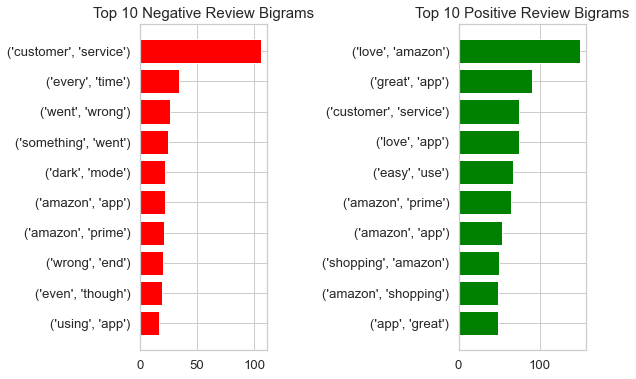

In [124]:
# create a 1-by-2 figure of the ten most common bigrams in negative (left plot) and positive (right plot) reviews
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.barh(n_bigrams['words'], n_bigrams['freq'], color='red')
ax1.set_title('Top 10 Negative Review Bigrams',size=15)

ax2.barh(p_bigrams['words'], p_bigrams['freq'], color='green')
ax2.set_title('Top 10 Positive Review Bigrams',size=15)

fig.subplots_adjust(wspace=1.5) #Adjusts the space between the two plots

**Analysis:** After creating the top 10 negative review bigrams and top 10 positive review bigrams, we are able to see what words are important in determining what reviews are positive and negative. With regards to negative reviews, we see that reviews mentioning "customer, service, every, time, and wrong" give a negative connotation from the customer. It seems like there is an issue around customer service and reocurrences of issues. With regards to positive reviews, we see that reviews mentioning "love, amazon, app, customer, and service" give a more positive connotation from customers. Some customers seem to actually like the customer service, and the app and service is seamless.

# Exercise 4: Discuss Results [10 points]

Comment on the relative merits behind each approach (ie, classifying via a ML model vs sentiment analysis via VADER). How could you use these tools to modify the app to address consumer concerns and maintain what they like?

**Answer:** Both approaches, classifying via a machine learning model and sentiment analysis via VADER, have their flaws and merits. First, the machine learning approach is definitely more accurate when it comes to understanding review sentiment. It is nice to be able to tune the models to gain accuracy, but the extremely long model run times is an issue. The sentiment analysis by VADER is simple and quick, but there are not many ways to tune this analysis and make it a more accurate analysis method. Since customer service seems to be an issue and the app is maintained well, the company should sharpen its customer portal within the app and train their customer service employees slightly more. Additionally, customers have problems with dark mode in the app, so this feature should be removed or made easier to turn on and off. The last issue that must be address is it seems like orders are being delivered to the wrong address. Delivery algorithms in the app should be more accurate with regards to customer locations. Ultimately, the app is the best feature of Amazon, according to customers, so resources should be allocated to maintaining it.